In [35]:
import numpy as np
import cv2 as cv
import math
import matplotlib.pyplot as plt

MAX_GREYSCALE = 255

#Create Gaussian filter
def create_gaussian_filter(sigma):
    # How to choose size n
    n = 2*math.floor(sigma*3)+1
    # Precompute sigma*sigma
    sigma2 = sigma*sigma
    
    # Create a coordinate sampling from -n/2 to n/2 so that (0,0) will be at the center of the filter
    x = np.linspace(-n/2.0, n/2.0, n)
    y = np.linspace(-n/2.0, n/2.0, n)
    
    # Blank array for the Gaussian filter
    gaussian_filter = np.zeros((n,n))

    # Loop over all elements of the filter
    for i in range(0, len(x)):
        for j in range(0, len(y)):
            # Use the x and y coordinate sampling as the inputs to the 2D Gaussian function
            gaussian_filter[i,j] = (1/(2*math.pi*sigma2))*math.exp(-(x[i]*x[i]+y[j]*y[j])/(2*sigma2))
        
    # Normalize so the filter sums to 1
    return gaussian_filter/np.sum(gaussian_filter.flatten())

def import_im(filename):
    # Import image as grayscale by arg = 0
    im = cv.imread(filename, 0) * 1.0
    
    #im_uint8 = ((im - np.min(im)) * (1/(np.max(im) - np.min(im)) * MAX_GREYSCALE)).astype('uint8')
    return im

def convert_im_grayscale(im):
    return ((im - np.min(im)) * (1/(np.max(im) - np.min(im)) * MAX_GREYSCALE)).astype('uint8')

def blur_img(im_in, sigma_blur):
    g = create_gaussian_filter(sigma_blur)
    blur_im = cv.filter2D(im_in, -1 ,g)
    return blur_im

def vid_partial_derivative(frames_denoise):
    frames_gradx = []
    frames_grady = []
    for f in frames_denoise:
        gradx = cv.Sobel(f,cv.CV_64F,1,0,ksize=3)
        grady = cv.Sobel(f,cv.CV_64F,0,1,ksize=3)
        
        frames_gradx.append(gradx)
        frames_grady.append(grady)

    return [frames_gradx, frames_grady]

def img_partial_derivative(img):

    gradx = cv.Sobel(img,cv.CV_64F,1,0,ksize=3)
    grady = cv.Sobel(img,cv.CV_64F,0,1,ksize=3)

    return [gradx, grady]

def second_moment_matrix(Ix, Iy, size, img):
    h, w = size

    print("H:",h)
    print("W:",w)
    
    neighbor_distance = np.array([
                                [[-1,-1], [0,-1], [1,-1]],
                                [(-1,0), [0,0], [1,0]],
                                [[-1,1], [0,1], [1,1]]
                            ])

    for row in range(1, h-1):
        for col in range(1, w-1):
            point = np.array([col, row])
            M = 0.0
            for row_neighbor in neighbor_distance:
                for item in row_neighbor:
                    neighbor_point = point + item
                    itensity_x = Ix[neighbor_point[1], neighbor_point[0]]
                    itensity_y = Iy[neighbor_point[1], neighbor_point[0]]
                    intensity = np.array([itensity_x, itensity_y])
                    M += intensity * intensity.reshape(2,1)
                    #M += np.array([[itensity_x*itensity_x, itensity_x*itensity_y],[itensity_x*itensity_y, itensity_y*itensity_y]])

            eigen_val = np.linalg.eig(M)[0]
            if eigen_val[0] < 1000:
                img[row, col] = 0

    return img



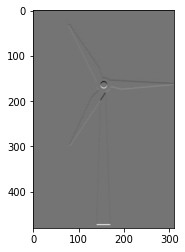

H: 480
W: 310
H: 480
W: 310


In [36]:

img_1_raw = import_im('/home/andrewweng/developer/optical-flow-segmentation-analysis/data/windmill/frame_059.jpg')
img_1 = convert_im_grayscale(img_1_raw)
img_1 = blur_img(img_1_raw, 1)


img_2_raw = import_im('/home/andrewweng/developer/optical-flow-segmentation-analysis/data/windmill/frame_060.jpg')
img_2 = convert_im_grayscale(img_2_raw)
img_2 = blur_img(img_2_raw, 1)

img_1_derivative = img_partial_derivative(img_1)

plt.imshow(img_1_derivative[1], cmap='gray')
plt.show()

img_2_derivative = img_partial_derivative(img_2)

Ix_1 = img_1_derivative[0]
Iy_1 = img_1_derivative[1]
img_1 = second_moment_matrix(Ix_1, Iy_1, img_1.shape, img_1)


Ix_2 = img_2_derivative[0]
Iy_2 = img_2_derivative[1]
img_2 = second_moment_matrix(Ix_2, Iy_2, img_2.shape, img_2)


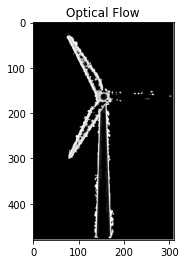

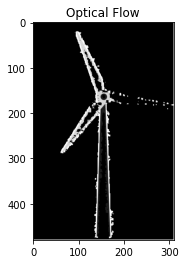

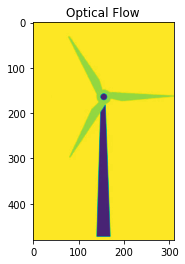

In [37]:
plt.imshow(img_1, cmap='gray')
plt.title('Optical Flow')
plt.show()

plt.imshow(img_2, cmap='gray')
plt.title('Optical Flow')
plt.show()

plt.imshow(img_1_raw)
plt.title('Optical Flow')
plt.show()


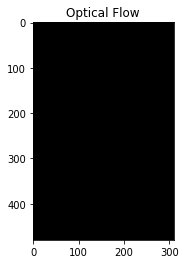

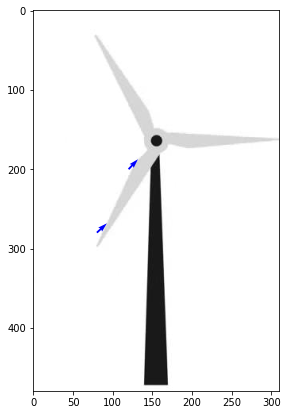

In [39]:
# hsv = np.zeros((img_1.shape[0],img_1.shape[1],3))
# hsv[..., 1] = 255
# print(hsv.shape)
# flow = None
# flow = cv.calcOpticalFlowFarneback(prev=img_1,
#                                     next=img_2, flow=flow,
#                                     pyr_scale=0.8, levels=15, winsize=5,
#                                     iterations=10, poly_n=5, poly_sigma=0,
#                                     flags=10)

# mag, ang = cv.cartToPolar(flow[..., 0], flow[..., 1])
# hsv[..., 0] = ang * 180 / np.pi / 2
# hsv[..., 2] = cv.normalize(mag, None, 0, 255, cv.NORM_MINMAX)

# image = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)


# plt.imshow(image)
# plt.title('Optical Flow')
# plt.show()


# flow = cv.calcOpticalFlowFarneback(img_1, img_2, flow=None, pyr_scale=0.5, levels=3, winsize=15, iterations=3, poly_n=5, poly_sigma=1.2, flags=0)

# img_1_raw = import_im('/home/andrewweng/developer/optical-flow-segmentation-analysis/data/cars/cars1_01.jpg')
# img_1 = blur_img(img_1_raw, 1)

# img_2_raw = import_im('/home/andrewweng/developer/optical-flow-segmentation-analysis/data/cars/cars1_02.jpg')
# img_2 = blur_img(img_2_raw, 1)

hsv = np.zeros((img_1.shape[0],img_1.shape[1],3))
hsv[..., 1] = 255

flow = cv.calcOpticalFlowFarneback(prev=img_1,
                                    next=img_2, flow=None,
                                    pyr_scale=0.1, levels=20, winsize=2,
                                    iterations=10, poly_n=5, poly_sigma=0,
                                    flags=10)

U = flow[..., 0]
V = flow[..., 1]


mag, ang = cv.cartToPolar(flow[..., 0], flow[..., 1])
hsv[..., 0] = ang * 180 / np.pi / 2
hsv[..., 2] = cv.normalize(mag, None, 0, 255, cv.NORM_MINMAX)
image = cv.cvtColor((hsv.astype('uint8') * 255), cv.COLOR_HSV2BGR)
image2 = cv.cvtColor(hsv.astype('float32'), cv.COLOR_HSV2BGR)

# plt.imshow(img_1)
# plt.title('Optical Flow')
# plt.show()

plt.imshow(image2)
plt.title('Optical Flow')
plt.show()

def display_pointy(im,U,V):
    stride = 40

    fig = plt.figure(figsize=(7, 7))
    plt.imshow(im, cmap='gray')
    for i in range(0, U.shape[0],stride):
        for j in range(0, U.shape[1], stride):
            if U[i,j] > 0.5:
                plt.quiver(j,i, V[i,j], U[i,j], color='blue')
    plt.show()


display_pointy(img_1_raw,U,V)
# return cv.cvtColor(hsv, cv.COLOR_HSV2BGR) 